## EXPERIMENT

In [222]:
%reset -f

import sys, pandas as pd, numpy as np, inspect, re as re, functools as functools, pickle, glob, warnings, os as os

from tqdm import tqdm
from hyperopt import hp, tpe, STATUS_OK, fmin, Trials
from hyperopt.fmin import fmin
from hyperopt.pyll.stochastic import sample

# sklearn packages
import sklearn.metrics as skm

# some options/variables
randomseed = 1 # the value for the random state used at various points in the pipeline
pd.options.display.max_rows = 50 # specify if you want the full output in cells rather the truncated list
pd.options.display.max_columns = 200

# to display multiple outputs in a cell without usin print/display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# append the scripts path to pythonpath
sys.path.append('../input/SCRIPTS/')

# ignore warnings (only if you are the kind that would code when the world is burning)
warnings.filterwarnings('ignore')

# plot inline
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# # import the various ml modules
import xgboost as xgb

############################################## import the custom modules ################################
import helperfuncs as helper
import feateng as fte
import misc as miscfun
from misc import ce_encodings, DataFrameImputer, scalers

# instantiate the classes
helpers = helper.helper_funcs()
cust_funcs = fte.custom_funcs()
feat_sel = miscfun.feat_selection()

#############################################################################################################
# global function to flatten columns after a grouped operation and aggregation
# outside all classes since it is added as an attribute to pandas DataFrames
def __my_flatten_cols(self, how="_".join, reset_index=True):
    how = (lambda iter: list(iter)[-1]) if how == "last" else how
    self.columns = [how(filter(None, map(str, levels))) for levels in self.columns.values] \
    if isinstance(self.columns, pd.MultiIndex) else self.columns
    return self.reset_index(drop=True) if reset_index else self
pd.DataFrame.my_flatten_cols = __my_flatten_cols

In [223]:
dep_dict = {'4A': 4, 
            '4B': 3, 
            '3A': 2, 
            '3B': 1, 
            '1A': 0}

In [224]:
## load backup
ads_backup = open('../working/ads_backup.pkl', 'rb')
train = pickle.load(ads_backup)
valid = pickle.load(ads_backup)
ytrain = pickle.load(ads_backup)
yvalid = pickle.load(ads_backup)
ads_backup.close()

In [225]:
np.array(np.unique(ytrain, return_counts=True)).T
np.array(np.unique(yvalid, return_counts=True)).T

array([[0.0000e+00, 1.0430e+03],
       [1.0000e+00, 2.4910e+03],
       [2.0000e+00, 1.8272e+04],
       [3.0000e+00, 1.0272e+04],
       [4.0000e+00, 3.5790e+03],
       [5.0000e+00, 1.0740e+03]])

array([[0.0000e+00, 7.4500e+02],
       [1.0000e+00, 1.7260e+03],
       [2.0000e+00, 1.2956e+04],
       [3.0000e+00, 7.6650e+03],
       [4.0000e+00, 2.7860e+03],
       [5.0000e+00, 8.8000e+02]])

In [226]:
dummy_train = train.copy()
dummy_valid = valid.copy()
dummy_train['response'] = ytrain.copy()
dummy_valid['response'] = yvalid.copy()

# filter for BANDS 0-5 and OPR above 1B
train_0to5 = dummy_train[(dummy_train['employee_band']<11) & (dummy_train['response']>0)]
valid_0to5 = dummy_valid[dummy_valid['employee_band']<11]
train_0to5.reset_index(drop=True, inplace=True)
valid_0to5.reset_index(drop=True, inplace=True)
ytrain_0to5 = train_0to5.response.values
yvalid_0to5 = valid_0to5.response.values
train_0to5.drop(columns=['response'], inplace=True)
valid_0to5.drop(columns=['response'], inplace=True)

train.shape, train_0to5.shape
valid.shape, valid_0to5.shape

np.array(np.unique(ytrain_0to5, return_counts=True)).T

((36731, 121), (8057, 121))

((26758, 121), (5906, 121))

array([[1.000e+00, 5.230e+02],
       [2.000e+00, 3.743e+03],
       [3.000e+00, 2.508e+03],
       [4.000e+00, 9.850e+02],
       [5.000e+00, 2.980e+02]])

In [227]:
ytrain_0to5 = ytrain_0to5-1
yvalid_0to5 = yvalid_0to5-1

In [228]:
np.array(np.unique(ytrain_0to5, return_counts=True)).T
np.array(np.unique(yvalid_0to5, return_counts=True)).T

array([[0.000e+00, 5.230e+02],
       [1.000e+00, 3.743e+03],
       [2.000e+00, 2.508e+03],
       [3.000e+00, 9.850e+02],
       [4.000e+00, 2.980e+02]])

array([[-1.000e+00,  1.840e+02],
       [ 0.000e+00,  3.430e+02],
       [ 1.000e+00,  2.641e+03],
       [ 2.000e+00,  1.776e+03],
       [ 3.000e+00,  7.270e+02],
       [ 4.000e+00,  2.350e+02]])

In [206]:
train_0to5.shape, ytrain_0to5.shape
valid_0to5.shape, yvalid_0to5.shape

train_0to5['response'] = ytrain_0to5
valid_0to5['response'] = yvalid_0to5
train_0to5.drop_duplicates(subset=['global_id', 'year'], inplace=True)
valid_0to5.drop_duplicates(subset=['global_id', 'year'], inplace=True)
ytrain_0to5 = np.array(train_0to5['response'])
yvalid_0to5 = np.array(valid_0to5['response'])
train_0to5.drop(columns=['response'], inplace=True)
valid_0to5.drop(columns=['response'], inplace=True)

train_0to5.shape, ytrain_0to5.shape
valid_0to5.shape, yvalid_0to5.shape

((8057, 121), (8057,))

((5906, 121), (5906,))

((8057, 121), (8057,))

((5904, 121), (5904,))

## MAIN FEATURE LIST EXPERIMENT

In [207]:
experiment_cols = ['global_id', 'year', 'zone', 'employee_band', 'opr_prev', 'opr_prev_prev',
                   'mr_pers_compgroup_year_comp_score_mean_leadership_competencies',
                   'mr_pers_compgroupl1_year_comp_score_mean_leadership_competencies_develop_people',
                   'mr_pers_compgroupl1_year_comp_score_mean_leadership_competencies_dream_big',
                   'mr_pers_compgroupl1_year_comp_score_mean_leadership_competencies_live_our_culture',
                  'time_in_band', 'position_tenure', #tenure features
                  'position_velocity', 'index_average', #career velocity
                  'net_target', 'target_delta', #target
                  'pdi_score', 'pdi_score_category', #pdi
                  'fc_count', 'lc_count', #PDP
                  'function', #function
                   'ebm_level', #EBM
                  'talent_pool', 'count_of_belts', #talent pool and belts flag
                   'talentpool_renomination', #talent pool renimation
                  'teamsize', 'teamsize_delta', #teamsize and teamsize between years
                  'engagement_score', 'manager_effectiveness_score'] #engagement features

In [208]:
train_exp = train_0to5[experiment_cols].copy()
valid_exp = valid_0to5[experiment_cols].copy()
ytrain_exp = ytrain_0to5.copy()
yvalid_exp = yvalid_0to5.copy()

In [209]:
train_exp.shape, valid_exp.shape
ytrain_exp.shape, yvalid_exp.shape

((8057, 30), (5904, 30))

((8057,), (5904,))

In [210]:
################ to filter out 2016 #####################

train_exp['response'] = ytrain_exp
trainnew = train_exp[train_exp['year']==2017]
trainnew.reset_index(drop=True, inplace=True)
ytrainnew = np.array(trainnew.response)
trainnew.drop(columns=['response'], inplace=True)
train_exp.drop(columns=['response'], inplace=True)

validnew = valid_exp.copy()
yvalidnew = yvalid_exp.copy()

In [211]:
trainnew.shape, validnew.shape
ytrainnew.shape, yvalidnew.shape

((4916, 30), (5904, 30))

((4916,), (5904,))

category encoding is happening ... 

category encoding completed 

[0]	train-mlogloss:1.59814	train-merror:0.297742	test-mlogloss:1.60281	test-merror:0.533572
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 100 rounds.
[10]	train-mlogloss:1.49198	train-merror:0.147835	test-mlogloss:1.54323	test-merror:0.475277
[20]	train-mlogloss:1.39702	train-merror:0.124202	test-mlogloss:1.49201	test-merror:0.473967
[30]	train-mlogloss:1.31224	train-merror:0.112731	test-mlogloss:1.44852	test-merror:0.474236
[40]	train-mlogloss:1.23547	train-merror:0.097689	test-mlogloss:1.41143	test-merror:0.469022
[50]	train-mlogloss:1.16622	train-merror:0.091337	test-mlogloss:1.37895	test-merror:0.467368
[60]	train-mlogloss:1.10237	train-merror:0.08173	test-mlogloss:1.35084	test-merror:0.466999
[70]	train-mlogloss:1.04331	train-merror:0.075091	test-mlogloss:1.32573	test-merror:0.467847
[80]	train-mlogloss:0.988591	train-merror:0

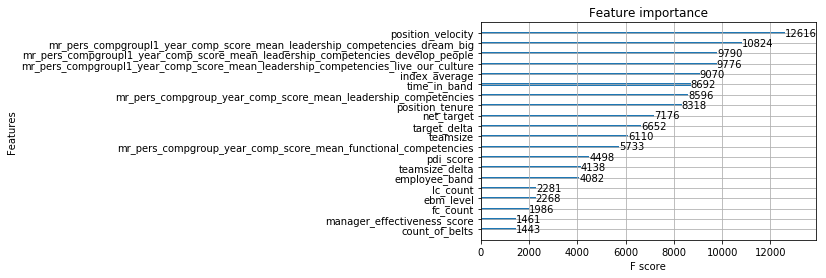

In [214]:
%run -i ../input/SCRIPTS/ml_xgboost_5class.py

xgb_model, xgb_feat_names, xgtrain, xgtest, xgbpred, xgb_pred_probs, pred1b = quick_model_xgb(train=trainnew.copy(), 
                                                                                      valid=validnew.copy(), 
                                                                                      ytrain=ytrainnew.copy(),
                                                                                      yvalid=yvalidnew.copy())

feature_importance_df1 = get_xgb_imp(xgb_model)
xgb.plot_importance(xgb_model, max_num_features=20)

In [218]:
feature_importance_df1.to_csv('final_experiment_feat_imp.csv', index=False)

In [215]:
%run -i ../input/SCRIPTS/rules_and_shape_without_1B.py

<Figure size 432x288 with 0 Axes>

In [216]:
valid_without1b = valid_0to5.copy()
valid_without1b['response'] = yvalid_0to5
valid_without1b = valid_without1b[valid_without1b['response']>=0]
valid_without1b.reset_index(drop=True, inplace=True)
yvalid_without1b = valid_without1b.response.values
valid_without1b.drop(columns=['response'], inplace=True)

In [217]:
rules_and_shape_rules_df = rules_shape_rules_fn(valid=valid_without1b.copy(), 
                                                    yvalid=yvalid_without1b.copy(), 
                                                    pred=xgbpred.copy(),
                                                    predprobs=xgb_pred_probs.copy())

0.5336479636427198
[[ 112  171   42    6   12]
 [ 154 1900  407   51  129]
 [  36  679  721  190  150]
 [   4  133  191  229  169]
 [   0   35   63   46   91]]
0.5341723474916973
the rules and shape predictions distribution
    a     b     dist
0  1A   306  5.34872
1  3A  1470  25.6948
2  3B  2918  51.0051
3  4A   532  9.29907
4  4B   495  8.65233


the rules and shape confusion matrix
[[ 112  171   42    6   12]
 [ 154 1900  420   46  121]
 [  36  679  737  180  144]
 [   4  133  205  218  166]
 [   0   35   66   45   89]]


the rules and shape precision score in the order -> [1A, 3B, 3A, 4B, 4A]
[36.60130719 65.11309116 50.13605442 44.04040404 16.72932331]


the zone level statistics
                   zone  response_mapped  exact  dev1  accuracy_exact  \
0                GLOBAL              641    366   582       57.098284   
1           ZONE AFRICA              369    171   329       46.341463   
2     ZONE ASIA PACIFIC              827    399   713       48.246675   
3           Z

In [ ]:
rules_and_shape_rules_df.to_csv('dummy.csv', index=False)

In [ ]:
def macro_factor_mapping(featimp, filename):
    feat_mapping = helpers.csv_read('../working/feature_macrofactor_mapping.csv')
    featimp = featimp.merge(feat_mapping, on=['feature'], how='left')
    featimp['importance_perc'] = featimp['importance']/featimp['importance'].sum()
    featimp = featimp.groupby(['macro_factor'])['importance_perc'].sum().reset_index()
    featimp.sort_values(by=['importance_perc'], ascending=True, inplace=True)
    featimp.reset_index(inplace=True, drop=True)
    
    featimp.to_csv(str('../working/' + filename + '.csv'), index=False)
    return featimp

f3 = macro_factor_mapping(featimp=feature_importance_df1, filename='final_experiment_feat_imp')

#### EXPERIMENT FEATURE LIST
- With Salary components (salary, compare ratio) added

In [8]:
sal_experiment_cols = ['global_id', 'year', 'zone', 'employee_band', 'opr_prev', 'opr_prev_prev', 
                   'mr_pers_compgroup_year_comp_score_mean_functional_competencies',
                   'mr_pers_compgroup_year_comp_score_mean_leadership_competencies',
                   'mr_pers_compgroupl1_year_comp_score_mean_leadership_competencies_develop_people',
                   'mr_pers_compgroupl1_year_comp_score_mean_leadership_competencies_dream_big',
                   'mr_pers_compgroupl1_year_comp_score_mean_leadership_competencies_live_our_culture',
                  'time_in_band', 'position_tenure', #tenure features
                  'position_velocity', 'index_average', #career velocity
                  'net_target', 'target_delta', #target
                  'pdi_score', 'pdi_score_category', #pdi
                  'fc_count', 'lc_count', #PDP
                  'function', #function
                   'ebm_level', #EBM
                  'talent_pool', 'count_of_belts', #talent pool and belts flag
                   'talentpool_renomination', #talent pool renimation
                  'teamsize', 'teamsize_delta', #teamsize and teamsize between years
                  'engagement_score', 'manager_effectiveness_score', #engagement features
                  'mod_salary', 'compare_ratio'] #salary features

In [9]:
train_salexp = train_0to5[sal_experiment_cols].copy()
valid_salexp = valid_0to5[sal_experiment_cols].copy()
ytrain_salexp = ytrain_0to5.copy()
yvalid_salexp = yvalid_0to5.copy()

In [10]:
################ to filter out 2016 #####################

train_salexp['response'] = ytrain_salexp
trainnew = train_salexp[train_salexp['year']==2017]
trainnew.reset_index(drop=True, inplace=True)
ytrainnew = np.array(trainnew.response)
trainnew.drop(columns=['response'], inplace=True)
train_salexp.drop(columns=['response'], inplace=True)

validnew = valid_salexp.copy()
yvalidnew = yvalid_salexp.copy()

In [11]:
trainnew.shape, ytrainnew.shape
validnew.shape, yvalidnew.shape

((4916, 32), (4916,))

((5721, 32), (5721,))

category encoding is happening ... 

category encoding completed 

[0]	train-mlogloss:1.56373	train-merror:0.358458	test-mlogloss:1.57805	test-merror:0.513069
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 50 rounds.
[10]	train-mlogloss:1.22003	train-merror:0.217011	test-mlogloss:1.37112	test-merror:0.473554
[20]	train-mlogloss:1.00745	train-merror:0.183791	test-mlogloss:1.26257	test-merror:0.472379
[30]	train-mlogloss:0.861217	train-merror:0.158048	test-mlogloss:1.20144	test-merror:0.468686
[40]	train-mlogloss:0.750273	train-merror:0.132969	test-mlogloss:1.16452	test-merror:0.467579
[50]	train-mlogloss:0.670593	train-merror:0.116369	test-mlogloss:1.14124	test-merror:0.466134
[60]	train-mlogloss:0.608043	train-merror:0.098113	test-mlogloss:1.12771	test-merror:0.467013
[70]	train-mlogloss:0.55618	train-merror:0.086005	test-mlogloss:1.11996	test-merror:0.467368
[80]	train-mlogloss:0.513748	train-merr

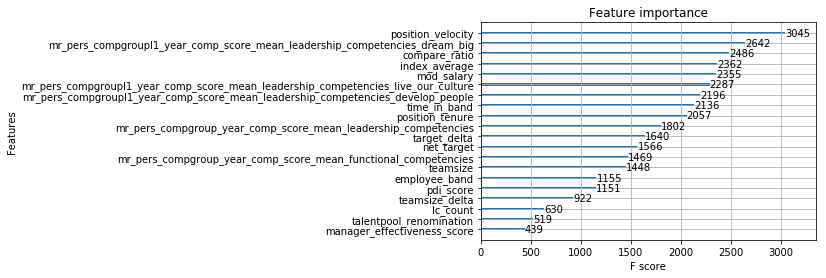

In [12]:
%run -i ../input/SCRIPTS/ml_xgboost_5class.py

xgb_model, xgb_feat_names, xgtrain, xgtest, xgbpred, xgb_pred_probs = quick_model_xgb(train=trainnew.copy(), 
                                                                                      valid=validnew.copy(), 
                                                                                      ytrain=ytrainnew.copy(),
                                                                                      yvalid=yvalidnew.copy())

feature_importance_df1 = get_xgb_imp(xgb_model)
xgb.plot_importance(xgb_model, max_num_features=20)
feature_importance_df1.to_csv('sal_experiment_feature_importance.csv', index=False)

In [39]:
sal_rules_and_shape_rules_df = rules_shape_rules_fn(valid=valid_0to5.copy(), 
                                                    yvalid=yvalid_0to5.copy(), 
                                                    pred=xgbpred.copy(),
                                                    predprobs=xgb_pred_probs.copy())

0.5325991959447649
[[ 103  179   41    6   14]
 [ 157 1889  420   46  129]
 [  37  689  729  173  148]
 [   4  136  184  235  167]
 [   0   33   56   55   91]]
0.5325991959447649
the rules and shape predictions distribution
    a     b     dist
0  1A   301  5.26132
1  3A  1466  25.6249
2  3B  2926  51.1449
3  4A   532  9.29907
4  4B   496  8.66981


the rules and shape confusion matrix
[[ 103  179   42    5   14]
 [ 157 1889  429   45  121]
 [  37  689  740  167  143]
 [   4  136  195  226  165]
 [   0   33   60   53   89]]


the rules and shape precision score in the order -> [1A, 3B, 3A, 4B, 4A]
[34.2192691  64.55912509 50.47748977 45.56451613 16.72932331]


the zone level statistics
                   zone  response_mapped  exact  dev1  accuracy_exact  \
0                GLOBAL              641    363   580       56.630265   
1           ZONE AFRICA              369    170   326       46.070461   
2     ZONE ASIA PACIFIC              827    389   705       47.037485   
3           Z

#### EXPERIMENT FEATURE LIST
- Without the Career Velocity and Historical OPR components

In [43]:
no_cv_opr_experiment_cols = ['global_id', 'year', 'zone', 'employee_band',
                   'mr_pers_compgroup_year_comp_score_mean_functional_competencies',
                   'mr_pers_compgroup_year_comp_score_mean_leadership_competencies',
                   'mr_pers_compgroupl1_year_comp_score_mean_leadership_competencies_develop_people',
                   'mr_pers_compgroupl1_year_comp_score_mean_leadership_competencies_dream_big',
                   'mr_pers_compgroupl1_year_comp_score_mean_leadership_competencies_live_our_culture',
                  'time_in_band', 'position_tenure', #tenure features
                  'net_target', 'target_delta', #target
                  'pdi_score', 'pdi_score_category', #pdi
                  'fc_count', 'lc_count', #PDP
                  'function', #function
                   'ebm_level', #EBM
                  'talent_pool', 'count_of_belts', #talent pool and belts flag
                   'talentpool_renomination', #talent pool renimation
                  'teamsize', 'teamsize_delta', #teamsize and teamsize between years
                  'engagement_score', 'manager_effectiveness_score'] #engagement features

In [44]:
train_nocvoprexp = train_0to5[no_cv_opr_experiment_cols].copy()
valid_nocvoprexp = valid_0to5[no_cv_opr_experiment_cols].copy()
ytrain_nocvoprexp = ytrain_0to5.copy()
yvalid_nocvoprexp = yvalid_0to5.copy()

In [45]:
################ to filter out 2016 #####################

train_nocvoprexp['response'] = ytrain_nocvoprexp
trainnew2 = train_nocvoprexp[train_nocvoprexp['year']==2017]
trainnew2.reset_index(drop=True, inplace=True)
ytrainnew2 = np.array(trainnew2.response)
trainnew2.drop(columns=['response'], inplace=True)
train_nocvoprexp.drop(columns=['response'], inplace=True)

validnew2 = valid_nocvoprexp.copy()
yvalidnew2 = yvalid_nocvoprexp.copy()

category encoding is happening ... 

category encoding completed 

[0]	train-mlogloss:1.56808	train-merror:0.386571	test-mlogloss:1.58499	test-merror:0.577589
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 50 rounds.
[10]	train-mlogloss:1.27144	train-merror:0.270996	test-mlogloss:1.41288	test-merror:0.513635
[20]	train-mlogloss:1.08315	train-merror:0.239223	test-mlogloss:1.32022	test-merror:0.513812
[30]	train-mlogloss:0.946617	train-merror:0.212796	test-mlogloss:1.26702	test-merror:0.512367
[40]	train-mlogloss:0.847255	train-merror:0.186141	test-mlogloss:1.23616	test-merror:0.512494
[50]	train-mlogloss:0.766267	train-merror:0.164731	test-mlogloss:1.21763	test-merror:0.510356
[60]	train-mlogloss:0.704443	train-merror:0.144889	test-mlogloss:1.20698	test-merror:0.510027
[70]	train-mlogloss:0.655899	train-merror:0.127822	test-mlogloss:1.20042	test-merror:0.510559
[80]	train-mlogloss:0.612885	train-mer

<Figure size 432x288 with 0 Axes>

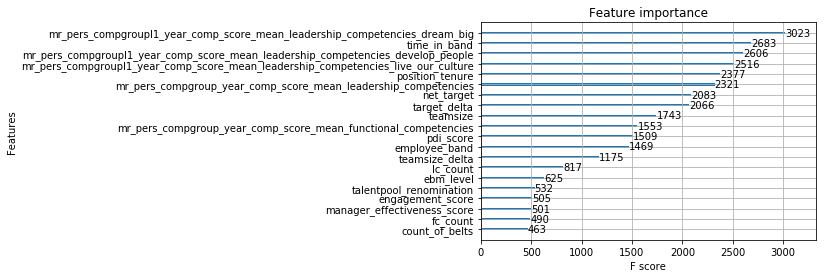

In [46]:
%run -i ../input/SCRIPTS/ml_xgboost_5class.py

xgb_model2, xgb_feat_names2, xgtrain2, xgtest2, xgbpred2, xgb_pred_probs2 = quick_model_xgb(train=trainnew2.copy(), 
                                                                                      valid=validnew2.copy(), 
                                                                                      ytrain=ytrainnew2.copy(),
                                                                                      yvalid=yvalidnew2.copy())

feature_importance_df2 = get_xgb_imp(xgb_model2)
xgb.plot_importance(xgb_model2, max_num_features=20)
feature_importance_df2.to_csv('no_cv_opr_experiment_feature_importance.csv', index=False)

In [40]:
no_cv_opr_rules_and_shape_rules_df = rules_shape_rules_fn(valid=valid_0to5.copy(), 
                                                    yvalid=yvalid_0to5.copy(), 
                                                    pred=xgbpred2.copy(),
                                                    predprobs=xgb_pred_probs2.copy())

0.49344520188778185
[[ 101  178   37   13   14]
 [ 164 1733  474  133  137]
 [  27  721  682  188  158]
 [   7  172  167  230  150]
 [   0   52   55   51   77]]
0.4939695857367593
the rules and shape predictions distribution
    a     b     dist
0  1A   299  5.22636
1  3A  1467  25.6424
2  3B  2856  49.9213
3  4A   512  8.94948
4  4B   587  10.2604


the rules and shape confusion matrix
[[ 101  178   40   11   13]
 [ 164 1733  488  130  126]
 [  27  721  700  178  150]
 [   7  172  180  218  149]
 [   0   52   59   50   74]]


the rules and shape precision score in the order -> [1A, 3B, 3A, 4B, 4A]
[33.77926421 60.67927171 47.71642808 37.13798978 14.453125  ]


the zone level statistics
                   zone  response_mapped  exact  dev1  accuracy_exact  \
0                GLOBAL              641    326   561       50.858034   
1           ZONE AFRICA              369    174   332       47.154472   
2     ZONE ASIA PACIFIC              827    373   702       45.102781   
3           